In [1]:
from PIL import Image
import torch
from models.model import MyModel

/opt/conda/envs/mmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
args = argparse.Namespace(
    # Model setting
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-base",
    ffn=True,
    transformer_d_model=512,
    transformer_d_ff=2048,
    transformer_d_kv=64,
    transformer_num_heads=8,
    transformer_num_layers=2,
    transformer_num_decoder_layers=8,
    image_vocab_size=16384,
    loc_vocab_size=1000,
    vae_ckpt_path="checkpoints/vqgan.pt",
    max_source_length=256,
    max_target_length=256,
    # Train setting
    pretrain=True, 
    # Dir setting
    root_dir="/data01/",
    result_dir="results/pretrain/sun397/enc2_dec8",
)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
model = MyModel(args).to(device)
model.load(result_name='best.pth')

In [5]:
from transformers import AutoTokenizer
from torchvision import transforms
src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256)
tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(1000)] + [f"<img_{i}>" for i in range(args.image_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [6]:
pattern = r"<img_(\d+)>"

import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

# ImageNet

In [11]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='imagenet', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_dataset = get_dataset(args, dataset_name='imagenet', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

[389, 1023, 13, 3650, 3, 20400, 3, 5]
[32099]
[32099]
[32099]
[32099, 3650]
[32099, 3650, 32098]
[32099, 3650, 32098]
[32099, 3650, 32098]
[32099, 3650, 32098]


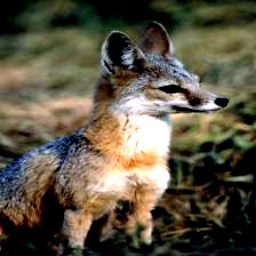

src_text: An image of<extra_id_0> fox.
tgt_text: <extra_id_0> kit<extra_id_1>
tensor([[  389,  1023,    13, 32099,     3, 20400,     5,     1]],
       device='cuda:0') tensor([[32099,  3650, 32098,     1]], device='cuda:0')


In [14]:
src_image, tgt_image, src_text, tgt_text = train_dataset[10]
with torch.no_grad():
    display(custom_to_pil(src_image))
    src_image = src_image.unsqueeze(0).to(device)
    print('src_text:', src_text)
    print('tgt_text:', tgt_text)
    src_text = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
    tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=args.max_target_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
    print(src_text, tgt_text)

    output = model(src_image, src_text, tgt_text, return_loss=False, num_beams=4)
    preds = tgt_tokenizer.batch_decode(output)
    print('pred', preds)

In [ ]:
tgt_tokenizer.decode([50,60,0,0], skip_padded=True)

# SUN397

In [7]:
from data import get_dataset

dataset = get_dataset(args, dataset_name='sun397', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_rate = 0.1
val_size = int(len(dataset) * val_rate)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(999))

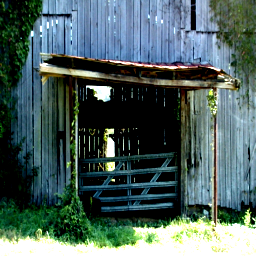

src_text: <extra_id_0> image of barndoor.
tgt_text: An<extra_id_1>
pred: An<extra_id_1>


In [68]:
src_image, tgt_image, src_text, tgt_text = train_dataset[1]
with torch.no_grad():
    display(custom_to_pil(src_image))
    src_image = src_image.unsqueeze(0).to(device)
    print('src_text:', src_text)
    print('tgt_text:', tgt_text)
    src_text = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
    tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=args.max_target_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']

    pred = model(src_image, src_text, tgt_text, return_loss=False)
    pred = pred[:,1:-1]
    preds = tgt_tokenizer.batch_decode(pred)
    print('pred:', preds[0])

# Places365

In [ ]:
from data import get_dataset
train_dataset = get_dataset(args, dataset_name='places365', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_dataset = get_dataset(args, dataset_name='places365', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

In [ ]:
src_image, tgt_image, src_text, tgt_text = val_dataset[99]
with torch.no_grad():
    display(custom_to_pil(src_image))
    src_image = src_image.unsqueeze(0).to(device)
    print('src_text', src_text)
    print('tgt_text', tgt_text)
    src_text = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
    tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=args.max_target_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']

    output = model(src_image, src_text, tgt_text, return_loss=False)
    preds = tgt_tokenizer.batch_decode(output)
    print('pred', preds)

# iNaturalist

In [ ]:
from data import get_dataset
# train_dataset = get_dataset(args, dataset_name='inaturalist', phase='train', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_dataset = get_dataset(args, dataset_name='inaturalist', phase='val', src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)

In [ ]:
src_image, tgt_image, src_text, tgt_text = val_dataset[12]
with torch.no_grad():
    display(custom_to_pil(src_image))
    src_image = src_image.unsqueeze(0).to(device)
    src_text = src_text.unsqueeze(0).to(device)
    print('src_text', src_tokenizer.batch_decode(src_text))
    tgt_text = tgt_text.unsqueeze(0).to(device)
    print('tgt_text', tgt_tokenizer.batch_decode(tgt_text))

    output = model(src_image, src_text, tgt_text, return_loss=False)
    preds = tgt_tokenizer.batch_decode(output)
    print('pred', preds)

# RedCaps

In [15]:
from data import get_dataset
dataset = get_dataset(args, dataset_name="redcaps", src_tokenizer=src_tokenizer, tgt_tokenizer=tgt_tokenizer)
val_rate = 0.1
val_size = int(len(dataset) * val_rate)
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(999))

[10803, 5420, 2535, 11972, 82, 2642, 16, 2343, 12, 1822, 34, 45, 8, 3412, 5, 1333, 1245, 936, 5]
[32099]
[32099, 5420]
[32099, 5420, 32098]
[32099, 5420, 32098]
[32099, 5420, 32098]
[32099, 5420, 32098]
[32099, 5420, 32098]
[32099, 5420, 32098]
[32099, 5420, 32098]
[32099, 5420, 32098, 1822]
[32099, 5420, 32098, 1822, 32097]
[32099, 5420, 32098, 1822, 32097]
[32099, 5420, 32098, 1822, 32097]
[32099, 5420, 32098, 1822, 32097]
[32099, 5420, 32098, 1822, 32097]
[32099, 5420, 32098, 1822, 32097]
[32099, 5420, 32098, 1822, 32097]
[32099, 5420, 32098, 1822, 32097]
[32099, 5420, 32098, 1822, 32097]


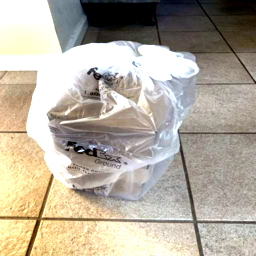

src_text Fed<extra_id_0> driver wrapped my package in plastic to<extra_id_1> it from the rain. Thanks nice human.
tgt_text <extra_id_0>Ex<extra_id_1> protect<extra_id_2>


In [16]:
src_image, tgt_image, src_text, tgt_text = train_dataset[6]
with torch.no_grad():
    display(custom_to_pil(src_image))
    src_image = src_image.unsqueeze(0).to(device)
    print('src_text', src_text)
    print('tgt_text', tgt_text)
    src_text = src_tokenizer(src_text, return_tensors='pt', padding=True).input_ids.to(device)
    tgt_text = tgt_tokenizer(tgt_text, return_tensors='pt', padding=True).input_ids.to(device)

    # generated = model(src_image, src_text, tgt_text, return_loss=False, num_beams=1)
    # generated = tgt_tokenizer.batch_decode(generated)
    # print('generated', generated)

# CC3M

In [ ]:
import os
cc3m_path = '/data/dataset/cc3m/'
train_tsv_path = os.path.join(cc3m_path, 'train.tsv')
train_img_path = os.path.join(cc3m_path, 'train')
with open(train_tsv_path, 'r') as f:
    lines = f.readlines()
print('train num: ', len(lines)-1)
for line in lines[1:]:
    img_name, caption = line.removesuffix('\n').split('\t')
    img_path = os.path.join(train_img_path, img_name)
    display(Image.open(img_path))
    print('img_name:', img_name)
    print('caption:', caption)
    break

val_tsv_path = os.path.join(cc3m_path, 'validation.tsv')
val_img_path = os.path.join(cc3m_path, 'val')
with open(val_tsv_path, 'r') as f:
    lines = f.readlines()
print('val num: ', len(lines)-1)

for line in lines[1:]:
    img_name, caption = line.removesuffix('\n').split('\t')
    img_path = os.path.join(val_img_path, img_name)
    display(Image.open(img_path))
    print('img_name:', img_name)
    print('caption:', caption)
    break

# CC12M

In [ ]:
import os
cc12m_path = '/data/dataset/cc12m/'
cc12m_tsv_path = os.path.join(cc12m_path, 'cc12m.tsv')
cc12m_img_path = os.path.join(cc12m_path, 'data')
with open(cc12m_tsv_path, 'r') as f:
    lines = f.readlines()
print('train num: ', len(lines)-1)
for line in lines[7:]:
    img_url, caption = line.removesuffix('\n').split('\t')
    img_name = img_url.split('/')[-1]
    img_path = os.path.join(cc12m_img_path, img_name)
    display(Image.open(img_path))
    print('img_name:', img_name)
    print('caption:', caption)
    break

In [ ]:
import tarfile
from tqdm import tqdm

cc12m_path = '/data/dataset/cc12m/'
output_path = '/data01/cc12m/'

img_path = os.path.join(output_path, 'train')
os.makedirs(img_path, exist_ok=True)

tsv_text = ''
tar_folder_path = os.path.join(cc12m_path, 'data')
tar_files = os.listdir(tar_folder_path)
for i, tar_name in enumerate(tar_files):
    tar_path = os.path.join(tar_folder_path, tar_name)
    tar = tarfile.open(tar_path)
    names = tar.getnames()
    for img_name in tqdm(names, desc=f'{i+1} / {len(tar_files)}'):
        if '.jpg' in img_name:
            name = img_name.split('.')[0]
            img_file = tar.extractfile(img_name)
            img = Image.open(img_file)
            img.save(os.path.join(img_path, img_name))
            txt_name = name + '.txt'
            txt_file = tar.extractfile(txt_name)
            caption = txt_file.read().decode('utf-8')
            tsv_text += f'{img_name}\t{caption}\n'

with open(os.path.join(output_path, 'train.tsv'), 'w') as f:
    f.write(tsv_text)

# 分割テスト

In [ ]:
import random

mask_tokens: list

def generate_target_ids(input_id, mask_prob):
    """This function takes a list of sentences and generates the pair (input_ids, target_ids) for pretraining the
    model. It implements in a simple way the final T5 denoising objective, as per HuggingFace documentation.

    :param mask_prob: Probability of masking a token.
    :param input_ids: A list of sublists, where the sublists are sequences of input ids (tokenized sentences). This
        mutable sublists are modified within this function, masking the tokens that the model has to denoise for
        pretraining.
    :return: The correspondent target sequences of ids for each input sentence, with the unmasked tokens.
    """
    target_id = []
    masked_indexes = sorted(random.sample(range(0, len(input_id)),  # sample a word index in sentence
                                            min(int(mask_prob * len(input_id)),  # number of tokens masked
                                                len(mask_tokens) - 1)))  # but never more than special tokens available
    mask = [(i in masked_indexes)  # this is True or False
            for i in range(len(input_id))]
    i = 0
    end = len(input_id)
    masked_spans_counter = 0
    while i < end:
        if mask[i]:
            current_words_masked = [input_id[i]]
            input_id[i] = mask_tokens[masked_spans_counter]
            masked_spans_counter += 1
            while i + 1 < end and mask[i + 1]:
                current_words_masked.append(input_id[i + 1])
                del input_id[i + 1]
                del mask[i + 1]
                end -= 1
            target_id.extend(current_words_masked)
        else:
            if len(target_id) == 0 or target_id[-1] != mask_tokens[masked_spans_counter]:
                target_id.append(mask_tokens[masked_spans_counter])
        i += 1
    return target_id

In [ ]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-base")
mask_tokens = tokenizer.additional_special_tokens_ids
mask_probability = 0.15

sentence = 'Thank you for inviting me to your party last week. I had a wonderful time.'
sequence = tokenizer.encode_plus(sentence, return_attention_mask=False, verbose=False)[
    "input_ids"]  # performance bottleneck 1 here
target_id = generate_target_ids(sequence, mask_probability)
sequence = torch.tensor(sequence)
sequence = torch.nn.functional.pad(sequence, (0, 512 - len(sequence)), 'constant', 0)
print(sequence.shape)
target_id = torch.tensor(target_id)
target_id = torch.nn.functional.pad(target_id, (0, 512 - len(target_id)), 'constant', 0)
print(target_id.shape)
print(tokenizer.decode(sequence))
print(tokenizer.decode(target_id))

In [ ]:
mask_tokens = src_tokenizer.additional_special_tokens_ids
mask_probability = 0.15

sentence = 'a photo of dog.'
sequence = tgt_tokenizer.encode_plus(sentence, return_attention_mask=False, verbose=False)["input_ids"]  # performance bottleneck 1 here
target_id = generate_target_ids(sequence, mask_probability)
print(sequence)
print(tgt_tokenizer.decode(sequence))
print(target_id)
print(tgt_tokenizer.decode(target_id))

In [ ]:
src_tokenizer.pad_token_id